In [1]:
import os 
import numpy as np 
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split 
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, Concatenate, Flatten, Dense, BatchNormalization, Dropout
from keras.applications import ResNet50, InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.cluster import KMeans
from pymongo import MongoClient 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

In [2]:
DIR = 'images'

In [3]:
# load dataset
images, image_paths, labels = [], [], []
for subdir in os.listdir(DIR):
    subdir_path = os.path.join(DIR, subdir)
    for file in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, file)

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = image / 255.0

        images.append(image)
        image_paths.append(file_path)
        labels.append(subdir)

In [4]:
NUM_CLASSES = len(set(labels))

In [5]:
images = np.array(images)
images.shape

(2340, 299, 299, 3)

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

original_labels = label_encoder.classes_

In [7]:
encoded_labels

array([ 0,  0,  0, ..., 10, 10, 10], dtype=int64)

In [8]:
inception_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))

In [9]:
global_average_layer = GlobalAveragePooling2D()(inception_model.output)
dense_layer = Dense(512, activation='relu')(global_average_layer)
dropout = Dropout(0.2)(dense_layer)
dense_layer = Dense(264, activation='relu')(dense_layer)
batch_norm = BatchNormalization()(dense_layer)
output = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

classification_model = Model(inputs=inception_model.input, outputs=output)

# Freeze the layers of the InceptionResNetV2 model
for layer in inception_model.layers:   layer.trainable = False

classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

unfreeze_layers = ['block8', 'block7', 'block6', 'block5']

# Unfreeze the specified layers
for layer in classification_model.layers:
    if any(layer.name.startswith(prefix) for prefix in unfreeze_layers):
        layer.trainable = True

# Re-compile the model after unfreezing layers
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(images, encoded_labels, test_size=0.15)

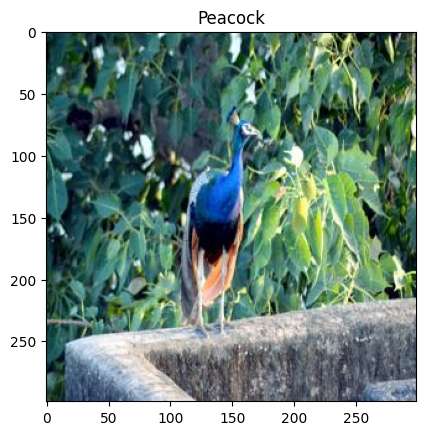

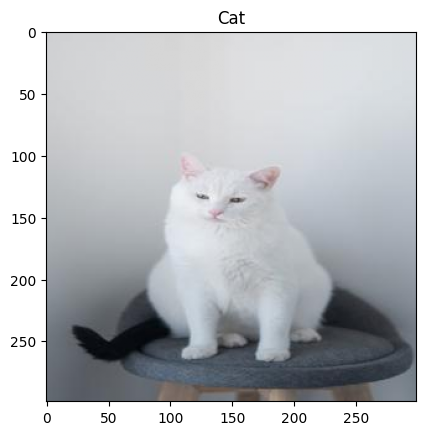

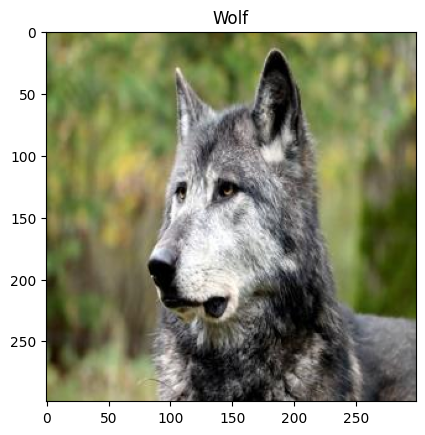

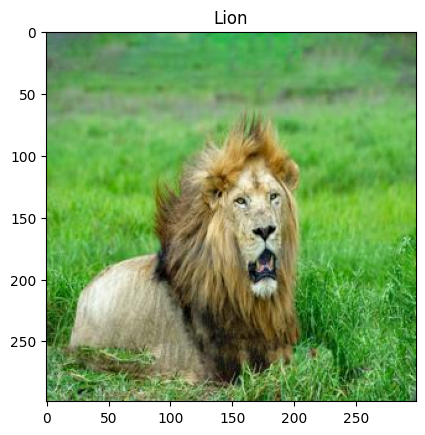

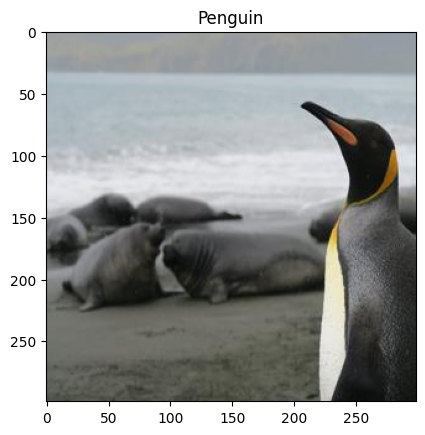

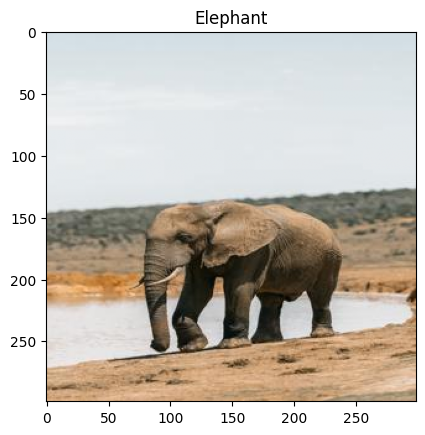

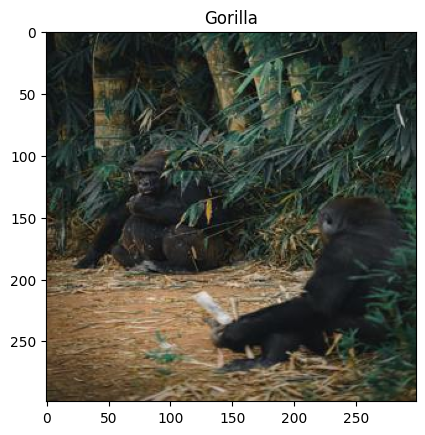

In [12]:
for i in range(0, len(train_images), 300):
    plt.imshow(train_images[i])
    plt.title(original_labels[train_labels[i]])
    plt.show()

In [13]:
history = classification_model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/5


63/63 [==============================] - 203s 3s/step - loss: 0.7068 - accuracy: 0.8140 - val_loss: 0.3782 - val_accuracy: 0.9031
Epoch 2/5
63/63 [==============================] - 173s 3s/step - loss: 0.2284 - accuracy: 0.9367 - val_loss: 0.3191 - val_accuracy: 0.9316
Epoch 3/5
63/63 [==============================] - 173s 3s/step - loss: 0.1305 - accuracy: 0.9658 - val_loss: 0.4170 - val_accuracy: 0.9231
Epoch 4/5
63/63 [==============================] - 180s 3s/step - loss: 0.0977 - accuracy: 0.9759 - val_loss: 0.4624 - val_accuracy: 0.9145
Epoch 5/5
63/63 [==============================] - 181s 3s/step - loss: 0.0646 - accuracy: 0.9824 - val_loss: 0.5320 - val_accuracy: 0.9202


In [14]:
encoder_model = Model(inputs=classification_model.inputs, outputs=classification_model.layers[-3].output)

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

In [16]:
classification_model.save('models\\model.h5')
encoder_model.save('models\\encoder.h5')

In [30]:
image_embeddings = encoder_model.predict(images)

74/74 [==============================] - 165s 2s/step


In [31]:
image_embeddings.shape

(2340, 512)

In [32]:
image_embeddings = image_embeddings.squeeze()

In [21]:
client = MongoClient('mongodb://localhost:27017/')
db = client['CBIR']

image_embeddings = image_embeddings.squeeze()

for path, embedding in zip(image_paths, image_embeddings):
    document = {
        'image_path': path,
        'embedding_vector': embedding.tolist(),
    }
    db.image_embeddings.insert_one(document)

In [25]:
# Apply KMeans clustering
num_clusters = NUM_CLASSES
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_indices = kmeans.fit_predict(image_embeddings)

# Update MongoDB documents with cluster information
for idx, doc in enumerate(db.image_embeddings.find()):
    db.image_embeddings.update_one(
        {'_id': doc['_id']},
        {'$set': {'cluster_index': int(cluster_indices[idx])}}
    )

In [28]:
import joblib

# Save the KMeans model to a file
joblib.dump(kmeans, 'models\\kmeans.pkl')

# Load the KMeans model from the file
loaded_kmeans = joblib.load('models\\kmeans.pkl')

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

def query_similar_images(query_embedding, top_k=10):
    # Assuming 'query_embedding' is the embedding of the query image
    query_cluster_index = int(kmeans.predict(query_embedding.reshape(1, -1))[0])

    # Retrieve embeddings from the same cluster
    cluster_data = db.image_embeddings.find({'cluster_index': query_cluster_index}, {'image_path': 1, 'embedding_vector': 1})
    # Extract _id and embedding_vector into separate lists
    cluster_paths = []
    cluster_embeddings = []

    for doc in cluster_data:
        cluster_paths.append(doc['image_path'])
        cluster_embeddings.append(doc['embedding_vector'])

    # Calculate cosine similarity between the query embedding and all embeddings in the cluster
    similarities = cosine_similarity(query_embedding.reshape(1, -1), cluster_embeddings)

    # Get indices of top-k similar images
    top_k_indices = similarities.argsort()[0][-top_k:][::-1]

    similar_images = [cluster_paths[_] for _ in top_k_indices]

    return similar_images


In [33]:
embedding = image_embeddings[0]

In [67]:
similar = query_similar_images(embedding)

In [68]:
similar

['images\\Cat\\0.jpg',
 'images\\Cat\\75.jpg',
 'images\\Cat\\210.jpg',
 'images\\Cat\\192.jpg',
 'images\\Cat\\31.jpg',
 'images\\Cat\\161.jpg',
 'images\\Cat\\10.jpg',
 'images\\Cat\\166.jpg',
 'images\\Cat\\70.jpg',
 'images\\Cat\\82.jpg']